In [1]:
#! pip install --quiet langgraph langchain_huggingface

### **Importing libraries**

In [2]:
                                                                                                                                                                                                                                                                                                                                                          ṇfrom langchain_huggingface import HuggingFaceEndpoint
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated, List, Dict, Any, Optional, Tuple
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from google.colab import userdata
import json
import requests
import os

### **Creating a State Class**

In [3]:
# Cell 2: Base “State” class
class State:
    """
    A base class for a “state node.” Subclasses must implement run(context)->str.
    """
    def run(self, context: Dict[str, Any]) -> str:
        # Every subclass will fill in context[“state”] if needed.
        messages: Annotated[list, add_messages]
        raise NotImplementedError("Subclasses must override run()")

### **Setting up Environment Variables**

In [4]:
HF_TOKEN = userdata.get('HF_TOKEN')
if not HF_TOKEN:
    raise ValueError("Please set HUGGINGFACEHUB_API_TOKEN in your environment.")

MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.3"
API_URL = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.3"
HEADERS = {"Authorization": f"Bearer {HF_TOKEN}"}

### **Defining a class for Mistral LLM**

In [5]:
class MistralLLM:
    # This is a wrapper class similar to init_chat_model of langchain
    def __init__(self):
        # Setting the API URL and HuggingFace Token using __init__() method
        self.api_url = API_URL
        if not self.api_url:
            raise ValueError(
                "Please set both MISTRAL_API_URL and MISTRAL_API_KEY in your environment."
            )
        self.headers = {
            "Authorization": f"Bearer {HF_TOKEN}",
            "Content-Type": "application/json"
        }
    def invoke(
        self,
        *,
        messages: List[Dict[str, str]],
        temperature: Optional[float] = None,
        max_tokens: Optional[int] = None,
        **kwargs: Any
        ) -> Dict[str, Any]:

        user_input = messages[-1]["content"]
        #print("User: " + user_input)
        payload: Dict[str, Any] = {
            "inputs": user_input,
            "parameters": {
              "temperature": 0.7,
              "max_new_tokens": 700
            }
          }
        response = requests.post(self.api_url, headers=self.headers, json=payload)
        response.raise_for_status()
        return response.json()

### **Functions to extract Json object from the string generated by Mistral**

In [6]:
import json
from typing import Any, Union

def extract_json_object(raw: str) -> Union[dict, None]:
    """
    Finds the last “{ … }” JSON object in `raw` and returns it as a Python dict.
    If nothing parseable is found, returns None.
    """
    raw = raw.strip()
    start = raw.rfind("{")
    end = raw.rfind("}") + 1
    if 0 <= start < end:
        candidate = raw[start:end]
        try:
            return json.loads(candidate)
        except json.JSONDecodeError:
            pass
    return None


def parse_llm_response(response: Any) -> Union[dict, None]:
    """
    Given an LLM response of the form [{ "generated_text": "…some text… { …final JSON… }" }],
    find the last generated_text, feed it into extract_json_object, and return the dict.
    If no valid JSON is found, returns None.
    """
    # 1) If it's a list of dicts, grab the last element’s "generated_text"
    if isinstance(response, list) and response:
        last_item = response[-1]
        raw_text = last_item.get("generated_text", "")
        return extract_json_object(raw_text)

    # 2) If it’s a single dict with "generated_text", use that directly
    if isinstance(response, dict) and "generated_text" in response:
        return extract_json_object(response["generated_text"])

    # 3) If it’s just a raw string, try extracting from it
    if isinstance(response, str):
        return extract_json_object(response)

    return None

def extract_json_array_of_strings(raw: str) -> list[str] | None:
    """
    Finds the last “[ … ]” JSON array in `raw` and returns it as a Python list of strings.
    If nothing parseable is found, returns None.
    """
    raw = raw.strip()
    start = raw.rfind("[")
    end = raw.rfind("]") + 1
    if 0 <= start < end:
        candidate = raw[start:end]
        try:
            arr = json.loads(candidate)
            if isinstance(arr, list) and all(isinstance(x, str) for x in arr):
                return arr
        except json.JSONDecodeError:
            pass
    return None

### **Prompt to Generate the Opening Scene**

In [7]:
def generate_opening_scene() -> tuple[str, list[str]]:
    """
    Ask Mistral to produce a JSON object:
      { "scene": "...", "choices": ["...","...","...","..."] }
    We then extract that last { … } from Mistral’s output.
    """
    prompt = """
    You are a master storyteller in the style of Stranger Things, weaving a suspenseful, 1980s‐inspired mystery in a small town beset by supernatural forces.
    Begin by crafting a vivid opening scene that places the player at ground zero of a strange phenomenon—perhaps a flickering streetlamp, a whispering forest, or the crackle of a mysterious radio signal. Your description should be exactly 2–3 sentences long and evoke the eerie atmosphere, subtle dread, and hint at a hidden otherworldly threat lurking just beyond sight.
    After the scene, present exactly four distinct choices for how the player can proceed next.
    Each choice should capture the tone of Stranger Things—teams of friends, secret government labs, eerie creatures, or cryptic clues.
    Format your output as a single JSON object with two keys:
    {
      "scene": "<2–3 sentence description of the opening, full of suspense and supernatural hints>",
      "choices": ["<choice 1>", "<choice 2>", "<choice 3>", "<choice 4>"]
    }
  **Instructions:**
    - Keep the scene concise (2–3 sentences), focusing on sensory details (sight, sound, atmosphere).
    - Choices must be numbered implicitly by their order in the array and should be short, action‐oriented strings (no numbers or punctuation inside the choice text).
    - Make each choice feel like a genuine “Stranger Things” decision—investigate a dimly lit laboratory, rally a group of friends, follow a strange noise into the woods, or consult a reclusive expert.
    - Output **ONLY** valid JSON (no extra narration or commentary).


""".strip()
    llm = MistralLLM()
    raw = llm.invoke(
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=700
    )
    #print(f"The type of raw is {type(raw)}")
    j = parse_llm_response(raw)
    if not j or "scene" not in j or "choices" not in j:
        raise RuntimeError(f"Could not parse opening JSON. Raw output:\n{raw}")
    return j["scene"], j["choices"]

### **Prompt to Generate Next Scene**

In [8]:
def generate_next_scene(prev_scene: str, chosen_choice: str) -> tuple[str, list[str]]:
    """
    Given the previous scene text and which choice the player picked, ask Mistral
    for the next scene (2–3 sentences) plus four new choices. Expect a JSON object back.
    """
    prompt = f"""
      You are continuing a suspenseful, Stranger Things–inspired interactive adventure. The previous scene was:
      \"\"\"
      {prev_scene}
      \"\"\"


      The player chose: "{chosen_choice}"

      Now, describe in vivid detail what happens next, using exactly 2–3 sentences that capture the eerie atmosphere, creeping tension, and hints of supernatural danger. After your description, present exactly four distinct next steps the player can take—each one should feel like a genuine Stranger Things decision (e.g., venturing deeper into a shadowy lab, warning a friend about the strange signals, exploring a hidden tunnel under the school, or seeking help from an expert).

      Format your output as a JSON object with two keys:
      {{
      "scene": "<2–3 sentence continuation, full of suspense, character insight, and supernatural hints>",
      "choices": ["<choice A>", "<choice B>", "<choice C>", "<choice D>"]
      }}
    **Instructions:**
      - Keep the “scene” concise (2–3 sentences) and focus on sensory details (sound of distant whispers, flickering lights, unsettling silence).
      - Integrate character dynamics inspired by Stranger Things—highlight relationships, personal fears, or group motivations (e.g., a loyal friend’s concern, a scientist’s hidden agenda, or a newcomer’s curiosity), so the story feels emotionally insightful from the start.
      - Each choice must be a short, action‐oriented string (avoid numbers or punctuation inside the choice text).
      - Ensure the tone remains true to Stranger Things (mysterious government projects, loyal friendships, ominous creatures).
      - Output **ONLY** valid JSON (no extra commentary or exposition).

""".strip()
    llm = MistralLLM()
    raw = llm.invoke(
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=700
    )
    j = parse_llm_response(raw)
    if not j or "scene" not in j or "choices" not in j:
        raise RuntimeError(f"Could not parse next-scene JSON. Raw output:\n{raw}")
    return j["scene"], j["choices"]

### **Opening Scene Generation**

In [9]:
# ─── Cell 4 (updated) ───
class OpeningSceneState(State):
    def __init__(self):
        super().__init__()

    def run(self, context: Dict[str, Any]) -> Dict[str, Any]:
        # 1) Generate opening scene
        scene_text, choices = generate_opening_scene()

        # 2) Figure out new depth
        depth = context.get("depth", 0) + 1

        # 3) Print Scene and choices
        print("\n" + "=" * 40)
        print(f"Scene (Number {depth}):\n{scene_text}\n")
        print("Choices:")
        for idx, choice in enumerate(choices, start=1):
            print(f"  {idx}) {choice}")
        print("  q) Quit the game")

        sel = input("Enter 1–4 or 'q': ").strip().lower()

        # 4) Validate
        if sel not in {"1", "2", "3", "4", "q"}:
            print("Invalid choice. Please enter 1, 2, 3, 4, or q.")
            return {
                "last_sel": "invalid",
                "scene_text": scene_text,
                "choices": choices,
                "depth": depth
            }

        # 5) Return a dict of all updated fields
        return {
            "last_sel": sel,
            "scene_text": scene_text,
            "choices": choices,
            "depth": depth
        }


### **Next Scene Generation**

In [10]:
# ─── Cell 5 (updated) ───
class NextSceneState(State):
    def __init__(self):
        super().__init__()

    def run(self, context: Dict[str, Any]) -> Dict[str, Any]:

        prev_scene   = context.get("scene_text", "")
        prev_choices = context.get("choices", [])
        sel          = context.get("last_sel", None)
        depth        = context.get("depth", 1)

        # If Opening told us to quit, short‐circuit
        if sel == "q":
            return {"last_sel": "halt", "depth": depth}

        if sel not in {"1", "2", "3", "4"}:
            print("Retrying previous scene because the choice was invalid.")
            return {"last_sel": "invalid", "depth": depth}

        chosen_text = prev_choices[int(sel) - 1]
        next_text, next_choices = generate_next_scene(prev_scene, chosen_text)

        new_depth = depth + 1

        # 1) Print next scene + choices
        print("\n" + "=" * 40)
        print(f"Scene (Number {new_depth}):\n{next_text}\n")
        print("Choices:")
        for idx, choice in enumerate(next_choices, start=1):
            print(f"  {idx}) {choice}")
        print("  q) Quit the game")

        sel2 = input("Enter 1–4 or 'q': ").strip().lower()
        if sel2 not in {"1", "2", "3", "4", "q"}:
            print("Invalid choice. Please enter 1, 2, 3, 4, or q.")
            return {
                "last_sel": "invalid",
                "scene_text": next_text,
                "choices": next_choices,
                "depth": new_depth
            }

        if sel2 == "q":
            return {"last_sel": "halt", "depth": new_depth}
        # 2) Return updated state for the next iteration
        return {
            "last_sel": sel2,
            "scene_text": next_text,
            "choices": next_choices,
            "depth": new_depth
        }


### **Path to Generate Opening Scene based on selection**

In [11]:
# Cell 6: Two “path” functions for StateGraph
#
# _opening_path looks at context["last_sel"] (which we set in OpeningSceneState.run)
# and decides whether to go to “quit,” retry the opening scene, or move on to next_scene.
def _opening_path(ctx: Dict[str, Any]) -> str:
    while True:
        event = ctx.get("last_sel")
        if event is None or event == "invalid":
            # run the OpeningSceneState again
            sel = opening_state_node.run(ctx)
            ctx["last_sel"] = sel
            if sel == "invalid":
                continue  # ask again
            event = sel
        break

    # “q” → END, otherwise → “next_scene”
    if event == "quit":
        return END
    if event in {"1", "2", "3", "4"}:
        return "next_scene"
    # if someone typed “invalid” repeatedly, we’d have looped above
    return "opening_scene"

### **Path to generate Next scene based on selection**

In [12]:
# ─── Cell 7 (fixed) ───
def _next_path(ctx: Dict[str, Any]) -> str:
    sel = ctx.get("last_sel")

    # If they typed “halt” (i.e. reached max depth or “q”), go to END
    if sel == "halt":
        return END

    # If it was an invalid choice, loop back to next_scene
    if sel not in {"1", "2", "3", "4"}:
        return "invalid"

    # Otherwise it was a valid choice – advance to next_scene (StateGraph will
    # call next_state_node.run for you exactly once)
    return "next_scene"

### **Starting the Graph**

In [13]:
# ─── Cell 8 (corrected) ───
opening_state_node = OpeningSceneState()
next_state_node    = NextSceneState()

# 1) Remove the “State” argument here. Just call StateGraph() with no parameters.
# new: tell StateGraph that our state is a dict
graph_builder = StateGraph(input=dict, output=dict)


# 2) Pass the .run method itself as the action (callable)
graph_builder.add_node("opening_scene", opening_state_node.run)
graph_builder.add_node("next_scene",    next_state_node.run)


graph_builder.add_edge(START, "opening_scene")

graph_builder.add_conditional_edges(
    source="opening_scene",
    path=_opening_path,
    path_map={
        END:           END,               # Must use the END constant, not the string "END"
        #"invalid":     "opening_scene",
        "next_scene":  "next_scene"
    },
)

graph_builder.add_conditional_edges(
    source="next_scene",
    path=_next_path,
    path_map={
        END:           END,               # Again, map to the END constant
        #"invalid":     "next_scene",
        "next_scene":  "next_scene"
    },
)

graph = graph_builder.compile()

<ipython-input-13-dcb62f69e3d7>:7: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  graph_builder = StateGraph(input=dict, output=dict)


### **Displaying the Graph**

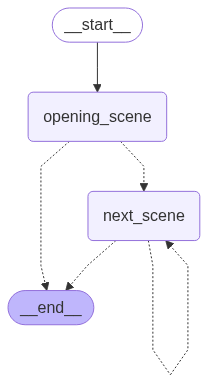

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    raise(Exception)

### **Graph Invoking**

In [15]:
# Cell 9: invoke the graph in a “main” guard
if __name__ == "__main__":
    # initial_context must include a place to store “last_sel” and “depth”
    initial_context: Dict[str, Any] = {
        "last_sel": None,
        "depth": 0
    }

    final_context = graph.invoke(
        initial_context,
        config={"recursion_limit": 1000}
    )

    print("\n" + "=" * 60)
    print("Sorry to see you go. We were having so much fun")
    print("Done. Thanks for playing!")



Scene (Number 1):
The player stumbles upon a dark, foggy forest, the trees whispering secrets as a faint, eerie melody floats through the air.

Choices:
  1) Press deeper into the woods, following the music.
  2) Return to the safety of the nearby town.
  3) Send a message to the local radio station to ask about the music.
  4) Search for clues among the fallen leaves on the forest floor.
  q) Quit the game
Enter 1–4 or 'q': 1

Scene (Number 2):
As the player ventures deeper into the woods, the music grows louder, and the trees' whispers become clearer. A sense of unease washes over the player, as if they're being watched by unseen eyes. A faint, flickering light pulses in the distance, casting eerie shadows.

Choices:
  1) Follow the music and the light
  2) Turn back, convinced it's a trap
  3) Split up to explore different paths
  4) Find a place to hide and observe from afar
  q) Quit the game
Enter 1–4 or 'q': 1

Scene (Number 3):
The music intensifies, and the light pulses rhyth